In [10]:
import pandas as pd 

file_path = '/Users/sanghyunkim/Desktop/573 Proj/cs573_final_proj/df_one_hot_encoded_normalized.csv'
data = pd.read_csv(file_path)
data.head()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),...,Father's occupation_172,Father's occupation_174,Father's occupation_175,Father's occupation_181,Father's occupation_182,Father's occupation_183,Father's occupation_192,Father's occupation_193,Father's occupation_194,Father's occupation_195
0,5,0.453026,0.472707,0.074267,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.415405,0.369970,0.049329,0.0,0.015578,0.015578,0.015578,0.036348,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.439165,0.449244,0.068395,0.0,0.021598,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.371466,0.364158,0.060896,0.0,0.018269,0.024358,0.018269,0.040887,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.285850,0.404478,0.128633,0.0,0.017151,0.025727,0.014293,0.035255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
num_entries = data.shape[0]  
num_features = data.shape[1] 

print(f"{num_entries} entries with {num_features} features")

4424 entries with 253 features


---
# Base Functions (data engineering)

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Data preparation function
def prepare_data(data, target_column):
    """
    Splits the data into train, validation, and test sets.
    :return: X_train, X_valid, X_test, y_train, y_valid, y_test
    """
    X = data.drop(columns=[target_column])
    y = data[target_column]
    y = y.replace({'1': 1, '0': 0, 'Enrolled': 2})  
    y = y.astype(int)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


# Feature reduction using correlation analysis
def reduce_features(X_train, threshold=0.75):
    """
    Removes highly correlated features based on the specified threshold.
    :return: Reduced X_train and list of correlated features
    """
    corr_matrix = pd.DataFrame(X_train).corr()
    correlated_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_features.add(colname)
    reduced_X_train = X_train.drop(columns=correlated_features, errors='ignore')
    return reduced_X_train, correlated_features


## Train & Evaluation

In [13]:
# Train and evaluate models
def train_and_evaluate_model(X_train, X_valid, X_test, y_train, y_valid, y_test, model_type="GradientBoosting"):
    """
    Trains a specified model and evaluates it on validation and test sets.
    :return: Trained model, validation accuracy, test accuracy
    """
    if model_type == "GradientBoosting":
        model = GradientBoostingClassifier(random_state=42)
    elif model_type == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose 'GradientBoosting' or 'XGBoost'.")

    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)

    val_accuracy = round(accuracy_score(y_valid, y_valid_pred), 4)
    test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)

    # Print performance metrics
    print(f"\n{model_type} Validation Accuracy: {val_accuracy}")
    print(f"{model_type} Test Accuracy: {test_accuracy}")
    print(f"\nClassification Report ({model_type}):\n", classification_report(y_test, y_test_pred))

    return model, val_accuracy, test_accuracy, y_test_pred


## Plotting Function

In [14]:
# Plot accuracies as histogram
def plot_accuracy_histogram(accuracies, save_path="accuracy_histogram.png"):
    """
    Plots a histogram of model accuracies (validation and test).
    Saves the plot as an image.
    """
    acc_df = pd.DataFrame(accuracies)
    acc_df = acc_df.melt(id_vars="Model", var_name="Set", value_name="Accuracy")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=acc_df, x="Model", y="Accuracy", hue="Set")
    plt.title("Validation and Test Accuracies for Models")
    plt.ylabel("Accuracy")
    plt.xlabel("Model")
    plt.ylim(0, 1)
    plt.savefig(save_path)  
    plt.show()


# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, title, save_path):
    """
    Plots a confusion matrix heatmap.
    Saves the plot as an image.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(save_path)  #
    plt.show()

## Modelling

In [15]:
# Get top 3 influential variables
def get_top_features(model, X_train, top_n=3):
    """
    Returns the top N most influential features from the model.
    """
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    top_features = sorted(zip(feature_importances, feature_names), reverse=True)[:top_n]
    print(f"\nTop {top_n} Features:")
    for importance, name in top_features:
        print(f"{name}: {importance:.4f}")
    return top_features


# Compare models with and without feature reduction
def compare_models(data, target_column):
    """
    Compares model performance with and without feature reduction.
    Plots confusion matrices and accuracy histograms.
    """
    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(data, target_column)

    # Train models without feature reduction
    print("\nTraining models without feature reduction...")
    gb_model, gb_val_acc, gb_test_acc, gb_y_test_pred = train_and_evaluate_model(
        X_train, X_valid, X_test, y_train, y_valid, y_test, model_type="GradientBoosting")
    xgb_model, xgb_val_acc, xgb_test_acc, xgb_y_test_pred = train_and_evaluate_model(
        X_train, X_valid, X_test, y_train, y_valid, y_test, model_type="XGBoost")

    # Perform feature reduction
    print("\nPerforming feature reduction...")
    reduced_X_train, correlated_features = reduce_features(X_train)
    print("Correlated features removed:", correlated_features)
    reduced_X_valid = X_valid.drop(columns=correlated_features, errors='ignore')
    reduced_X_test = X_test.drop(columns=correlated_features, errors='ignore')

    # Train models with reduced features
    print("\nTraining models with reduced features...")
    gb_model_reduced, gb_val_acc_reduced, gb_test_acc_reduced, gb_y_test_pred_reduced = train_and_evaluate_model(
        reduced_X_train, reduced_X_valid, reduced_X_test, y_train, y_valid, y_test, model_type="GradientBoosting")
    xgb_model_reduced, xgb_val_acc_reduced, xgb_test_acc_reduced, xgb_y_test_pred_reduced = train_and_evaluate_model(
        reduced_X_train, reduced_X_valid, reduced_X_test, y_train, y_valid, y_test, model_type="XGBoost")

    # Collect accuracy data
    accuracies = {
        "Model": ["GradientBoosting", "XGBoost", "GradientBoosting (Reduced)", "XGBoost (Reduced)"],
        "Validation Accuracy": [gb_val_acc, xgb_val_acc, gb_val_acc_reduced, xgb_val_acc_reduced],
        "Test Accuracy": [gb_test_acc, xgb_test_acc, gb_test_acc_reduced, xgb_test_acc_reduced]
    }

    # Plot and save accuracy histogram
    plot_accuracy_histogram(accuracies, save_path="accuracy_histogram.png")

    # Plot and save confusion matrices
    plot_confusion_matrix(y_test, gb_y_test_pred, "GradientBoosting (Original)", "gb_confusion_matrix.png")
    plot_confusion_matrix(y_test, xgb_y_test_pred, "XGBoost (Original)", "xgb_confusion_matrix.png")
    plot_confusion_matrix(y_test, gb_y_test_pred_reduced, "GradientBoosting (Reduced)", "gb_reduced_confusion_matrix.png")
    plot_confusion_matrix(y_test, xgb_y_test_pred_reduced, "XGBoost (Reduced)", "xgb_reduced_confusion_matrix.png")

    # Get top features
    print("\nTop Features for GradientBoosting (Reduced):")
    get_top_features(gb_model_reduced, reduced_X_train)

    print("\nTop Features for XGBoost (Reduced):")
    get_top_features(xgb_model_reduced, reduced_X_train)



Training models without feature reduction...

GradientBoosting Validation Accuracy: 0.766
GradientBoosting Test Accuracy: 0.7768

Classification Report (GradientBoosting):
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       219
           1       0.83      0.75      0.79       141
           2       0.56      0.41      0.47        79

    accuracy                           0.78       439
   macro avg       0.73      0.69      0.71       439
weighted avg       0.77      0.78      0.77       439


XGBoost Validation Accuracy: 0.7874
XGBoost Test Accuracy: 0.7745

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       219
           1       0.82      0.76      0.79       141
           2       0.50      0.43      0.46        79

    accuracy                           0.77       439
   macro avg       0.72      0.70      0.71       439
weighted avg     

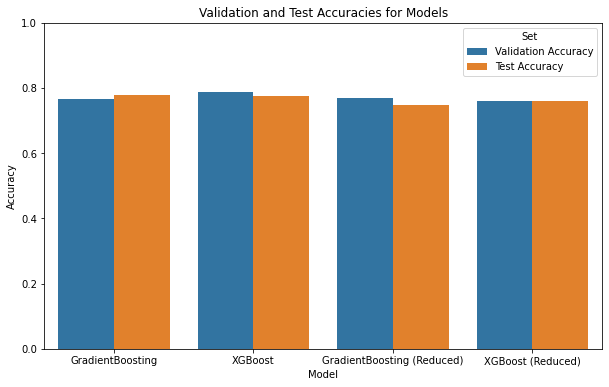

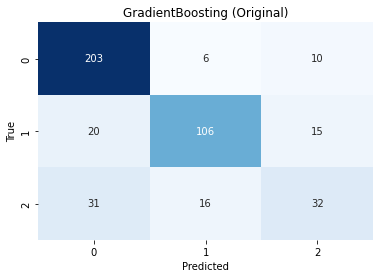

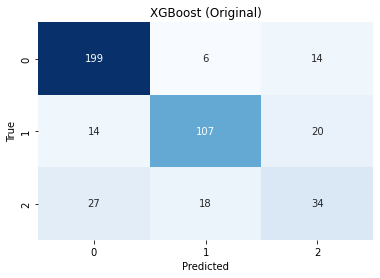

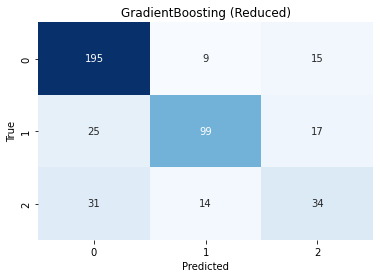

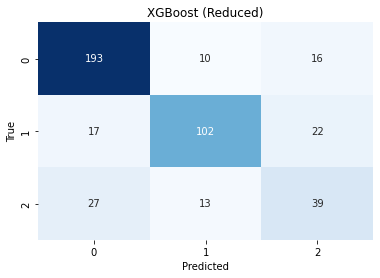


Top Features for GradientBoosting (Reduced):

Top 3 Features:
Curricular units 1st sem (approved): 0.4817
Tuition fees up to date_0: 0.0942
Curricular units 2nd sem (evaluations): 0.0789

Top Features for XGBoost (Reduced):

Top 3 Features:
Tuition fees up to date_0: 0.0645
Curricular units 1st sem (approved): 0.0512
Scholarship holder_0: 0.0209


In [16]:
compare_models(data, target_column="Target")


## Parameter Tuning

GradientBoosting - Learning Rate: 0.01, Max Depth: 3, Accuracy: 0.7449
XGBoost - Learning Rate: 0.01, Max Depth: 3, Accuracy: 0.7472
GradientBoosting - Learning Rate: 0.05, Max Depth: 3, Accuracy: 0.7677
XGBoost - Learning Rate: 0.05, Max Depth: 3, Accuracy: 0.7677
GradientBoosting - Learning Rate: 0.1, Max Depth: 3, Accuracy: 0.7768
XGBoost - Learning Rate: 0.1, Max Depth: 3, Accuracy: 0.7722
GradientBoosting - Learning Rate: 0.2, Max Depth: 3, Accuracy: 0.779
XGBoost - Learning Rate: 0.2, Max Depth: 3, Accuracy: 0.7882
GradientBoosting - Max Depth: 3, Learning Rate: 0.1, Accuracy: 0.7768
XGBoost - Max Depth: 3, Learning Rate: 0.1, Accuracy: 0.7722
GradientBoosting - Max Depth: 5, Learning Rate: 0.1, Accuracy: 0.7745
XGBoost - Max Depth: 5, Learning Rate: 0.1, Accuracy: 0.7859
GradientBoosting - Max Depth: 7, Learning Rate: 0.1, Accuracy: 0.779
XGBoost - Max Depth: 7, Learning Rate: 0.1, Accuracy: 0.7836
GradientBoosting - Max Depth: 9, Learning Rate: 0.1, Accuracy: 0.7768
XGBoost - M

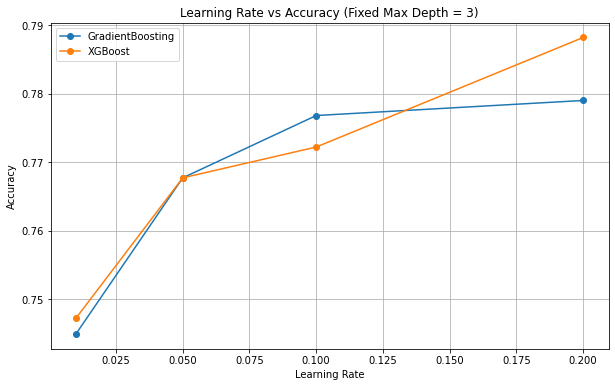

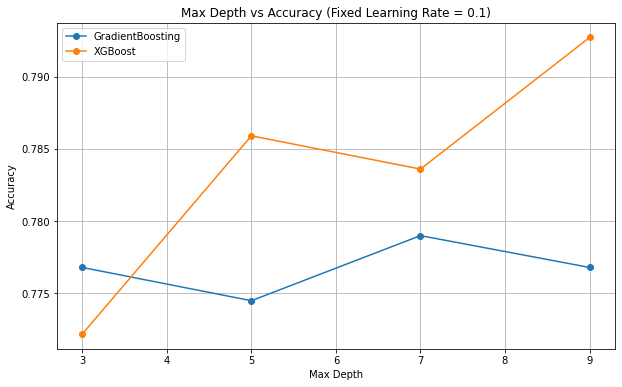

In [18]:
def tune_and_visualize_accuracy_fixed_params(data, target_column, learning_rates, max_depths, fixed_max_depth=3, fixed_learning_rate=0.1):
    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(data, target_column)

    results_lr = []
    results_md = []

    # Tune learning rate with fixed max depth
    for lr in learning_rates:
        gb_model = GradientBoostingClassifier(learning_rate=lr, max_depth=fixed_max_depth, random_state=42)
        gb_model.fit(X_train, y_train)
        gb_accuracy = round(accuracy_score(y_test, gb_model.predict(X_test)), 4)

        xgb_model = XGBClassifier(learning_rate=lr, max_depth=fixed_max_depth, use_label_encoder=False,
                                   eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_accuracy = round(accuracy_score(y_test, xgb_model.predict(X_test)), 4)

        results_lr.append(("GradientBoosting", lr, gb_accuracy))
        results_lr.append(("XGBoost", lr, xgb_accuracy))

        print(f"GradientBoosting - Learning Rate: {lr}, Max Depth: {fixed_max_depth}, Accuracy: {gb_accuracy}")
        print(f"XGBoost - Learning Rate: {lr}, Max Depth: {fixed_max_depth}, Accuracy: {xgb_accuracy}")

    # Tune max depth with fixed learning rate
    for depth in max_depths:
        gb_model = GradientBoostingClassifier(learning_rate=fixed_learning_rate, max_depth=depth, random_state=42)
        gb_model.fit(X_train, y_train)
        gb_accuracy = round(accuracy_score(y_test, gb_model.predict(X_test)), 4)

        xgb_model = XGBClassifier(learning_rate=fixed_learning_rate, max_depth=depth, use_label_encoder=False,
                                   eval_metric='logloss', random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_accuracy = round(accuracy_score(y_test, xgb_model.predict(X_test)), 4)

        results_md.append(("GradientBoosting", depth, gb_accuracy))
        results_md.append(("XGBoost", depth, xgb_accuracy))

        print(f"GradientBoosting - Max Depth: {depth}, Learning Rate: {fixed_learning_rate}, Accuracy: {gb_accuracy}")
        print(f"XGBoost - Max Depth: {depth}, Learning Rate: {fixed_learning_rate}, Accuracy: {xgb_accuracy}")

    # Convert results to DataFrame
    results_lr_df = pd.DataFrame(results_lr, columns=["Model", "Learning Rate", "Accuracy"])
    results_md_df = pd.DataFrame(results_md, columns=["Model", "Max Depth", "Accuracy"])

    # Plot results
    plot_learning_rate_accuracy(results_lr_df, fixed_max_depth)
    plot_max_depth_accuracy(results_md_df, fixed_learning_rate)


def plot_learning_rate_accuracy(results_df, fixed_max_depth):
    plt.figure(figsize=(10, 6))
    for model in results_df["Model"].unique():
        model_data = results_df[results_df["Model"] == model]
        plt.plot(model_data["Learning Rate"], model_data["Accuracy"], marker='o', label=model)

    plt.title(f"Learning Rate vs Accuracy (Fixed Max Depth = {fixed_max_depth})")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_max_depth_accuracy(results_df, fixed_learning_rate):
    plt.figure(figsize=(10, 6))
    for model in results_df["Model"].unique():
        model_data = results_df[results_df["Model"] == model]
        plt.plot(model_data["Max Depth"], model_data["Accuracy"], marker='o', label=model)

    plt.title(f"Max Depth vs Accuracy (Fixed Learning Rate = {fixed_learning_rate})")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


learning_rates = [0.01, 0.05, 0.1, 0.2]
max_depths = [3, 5, 7, 9]
tune_and_visualize_accuracy_fixed_params(data, target_column="Target", learning_rates=learning_rates, max_depths=max_depths)
